In [1]:
import os
import os.path
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [2]:
directory_path = r'C:/Users/borge/Desktop/HPLC DATA ARISTOLOCHIA_ANDREW'
os.chdir(directory_path)
%pwd

'C:\\Users\\borge\\Desktop\\HPLC DATA ARISTOLOCHIA_ANDREW'

### Converte os arquivos exportados para arquivos de tabela simples

In [3]:
def extract_data(file_path):
    data = []
    start_extraction = False

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("R.Time (min)"):
                start_extraction = True
                continue
            if start_extraction:
                columns = line.strip().split()
                if len(columns) == 2:
                    # Replace commas with dots in each column
                    columns = [col.replace(',', '.') for col in columns]
                    data.append(columns)

    return data

def main():
    input_folder = directory_path
    output_folder = directory_path

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        if file_name.endswith(".txt"):
            file_path = os.path.join(input_folder, file_name)
            data = extract_data(file_path)

            # Save the data into a new file
            output_file_path = os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}_table.csv")
            with open(output_file_path, 'w') as output_file:
                for row in data:
                    output_file.write('\t'.join(row) + '\n')

if __name__ == "__main__":
    main()


#### Extrai os dados importados para formar a tabela para análise

In [4]:
# Get a list of all files matching the pattern *_table.txt
file_list = glob.glob('*_table.csv')

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through each file and read its data into a DataFrame
for file in file_list:
    # Extracting the file name (excluding the extension) to use as a column header
    column_name = file.split('_table.csv')[0]
    
    # Assuming the files are tab-delimited, you can adjust the delimiter accordingly
    df = pd.read_csv(file, delimiter='\t')
    
    # Add the data to the combined DataFrame with the file name as the column header
    combined_df[column_name] = df.iloc[:, 1]  # Assuming you want the second column, adjust as needed

# Assuming the files are tab-delimited, you can adjust the delimiter accordingly
df1 = pd.read_csv(file, delimiter='\t', header=None)
axis = df1.iloc[:, 0]
    
# Set the row number after which you want to remove rows
row_to_remove_after = 4200  # Change this to the desired row number
# Remove rows after the specified row number
combined_df = combined_df.iloc[:row_to_remove_after]
axis = axis.iloc[:row_to_remove_after]

# Concatenate 'axis' DataFrame with 'combined_df'
combined_df2 = pd.concat([axis, combined_df], axis=1)
combined_df2.rename(columns={0:"RT(min)"},inplace=True)

# Save the combined DataFrame to a CSV file
combined_df2.to_csv('combined_data.csv', sep=";",index=False)

#### Análise dos dados

In [5]:
combined_df2.shape

(4200, 48)

<Figure size 1000x600 with 0 Axes>

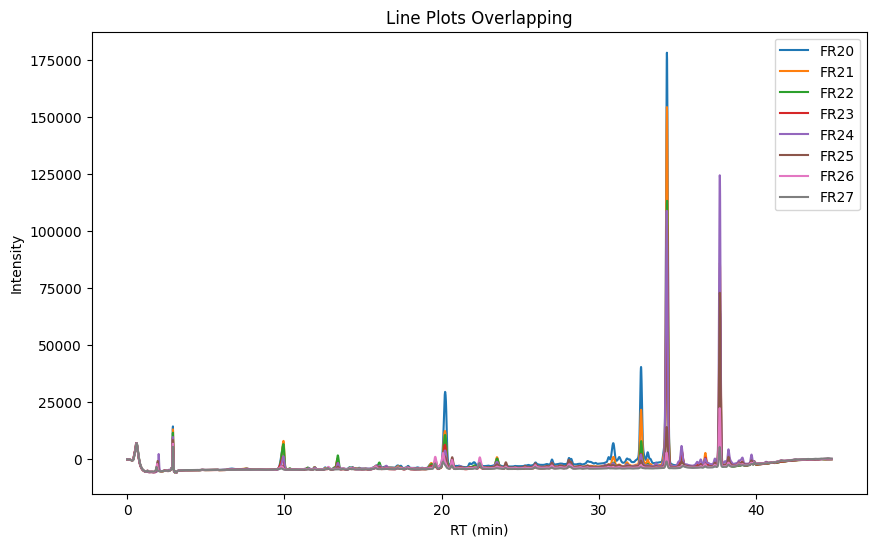

In [27]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the range of columns you want to plot (columns 4 to 8 in this case)
start_column = 25
end_column = 32

# Enable interactive mode in Jupyter Notebook
%matplotlib inline

# Plotting
plt.figure(figsize=(10, 6))

# Loop through the specified range of columns and plot a line
for column in combined_df2.columns[start_column:end_column + 1]:
    plt.plot(combined_df2['RT(min)'], combined_df2[column], label=column)

# Add labels and title
plt.xlabel('RT (min)')
plt.ylabel('Intensity')
plt.title('Line Plots Overlapping')

# Add a legend
plt.legend()

# Set the axis limits to enable zooming
#plt.axis([xmin, xmax, ymin, ymax])

# Show the plot
plt.show()


### PCA

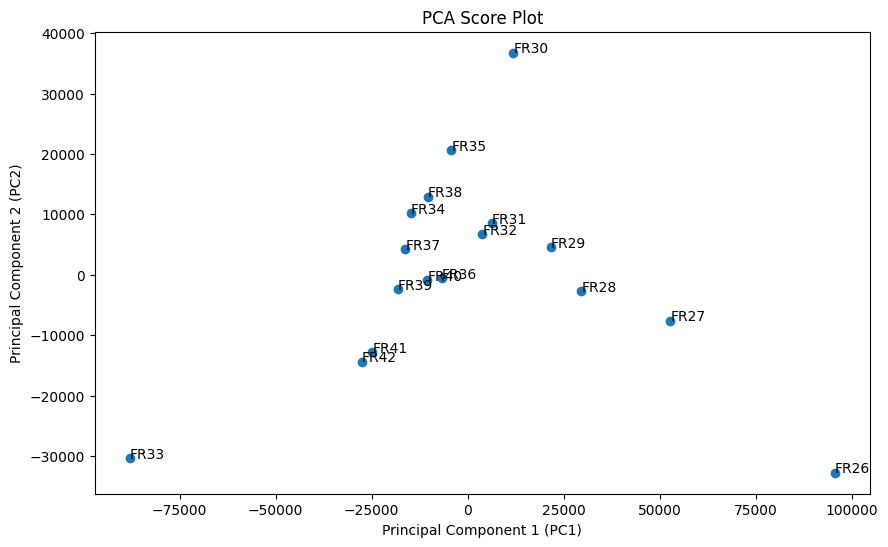

In [7]:
from sklearn.decomposition import PCA

# Extract the feature columns (excluding the 'RT(min)' column)
X = combined_df
X = X.T
X = X.iloc[30:] # se for mu

# Perform PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(X)

# Create a DataFrame for the scores
scores_df = pd.DataFrame(data=scores, columns=['PC1', 'PC2'])

# Score plot
plt.figure(figsize=(10, 6))
plt.scatter(scores_df['PC1'], scores_df['PC2'])

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Score Plot')

# Identify points on the plot using the index of X
for i, sample_name in enumerate(X.index):
    plt.annotate(sample_name, (scores_df['PC1'][i], scores_df['PC2'][i]))

# Show the plot
plt.show()

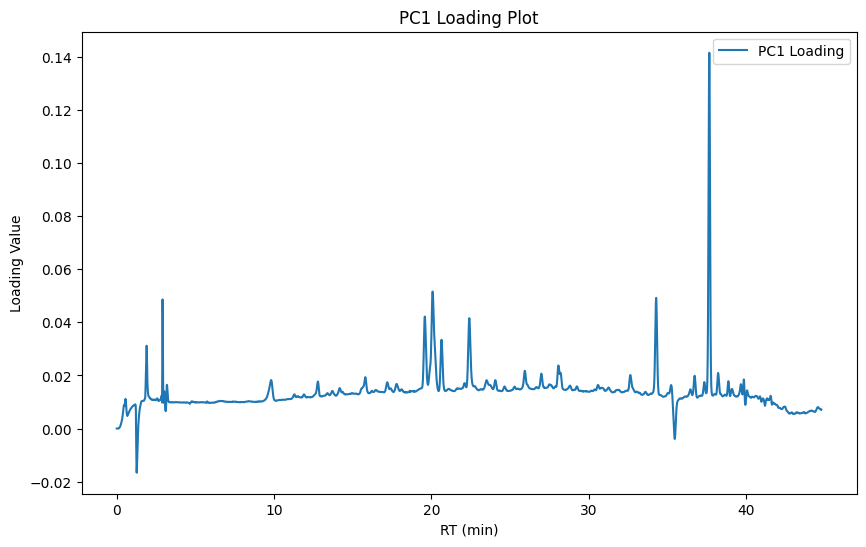

In [46]:
# Loadings Plot

# Access the loadings from the PCA object
loadings = pca.components_

# Plot the loadings for PC1
plt.figure(figsize=(10, 6))
plt.plot(combined_df2['RT(min)'], loadings[0], label='PC1 Loading')
plt.xlabel('RT (min)')
plt.ylabel('Loading Value')
plt.title('PC1 Loading Plot')
plt.legend()
plt.show()

# Plot the loadings for PC2
#plt.figure(figsize=(10, 6))
#plt.plot(combined_df2['RT(min)'], loadings[1], label='PC2 Loading')
#plt.xlabel('RT (min)')
#plt.ylabel('Loading Value')
#plt.title('PC2 Loading Plot')
#plt.legend()
#plt.show()

#### PLS-DA

In [55]:
# Create the Target Vector for the supervision tool (PLS-DA)
df_metadata = pd.read_csv("Metadata.csv", sep=";")
y = df_metadata['target_column']

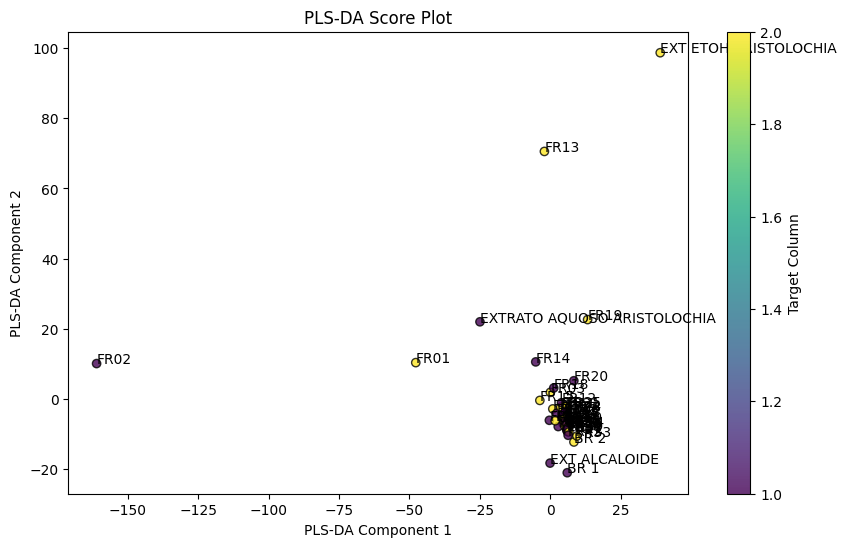

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Assuming combined_df2 is your DataFrame
# Replace 'your_data.csv' with your actual file or use your DataFrame directly
# combined_df2 = pd.read_csv('your_data.csv')

# Extract the feature columns (excluding the 'RT(min)' column)
X = combined_df2.iloc[:, 1:]
X = X.T

# Perform PLS-DA
plsr = PLSRegression(n_components=2)
plsr.fit(X, y)
scores = plsr.transform(X)

# Create a DataFrame for the scores
scores_df = pd.DataFrame(data=scores, columns=['PLS-DA Component 1', 'PLS-DA Component 2'])

# Score plot with color-coded points based on 'target_column'
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    scores_df['PLS-DA Component 1'],
    scores_df['PLS-DA Component 2'],
    c=y,
    cmap='viridis',  # Choose a colormap of your preference
    edgecolor='k',  # Add black edges for better visibility
    alpha=0.8  # Adjust the transparency if needed
)

# Add labels and title
plt.xlabel('PLS-DA Component 1')
plt.ylabel('PLS-DA Component 2')
plt.title('PLS-DA Score Plot')

# Identify points on the plot using the index of X
for i, sample_name in enumerate(X.index):
    plt.annotate(sample_name, (scores_df['PLS-DA Component 1'][i], scores_df['PLS-DA Component 2'][i]))

# Add colorbar
cbar = plt.colorbar(scatter, label='Target Column')

# Show the plot
plt.show()


###### Validation - PLS-DA

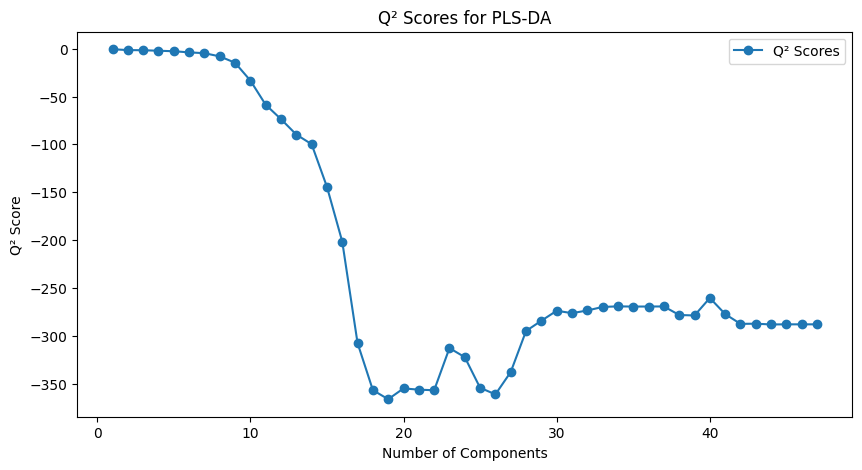

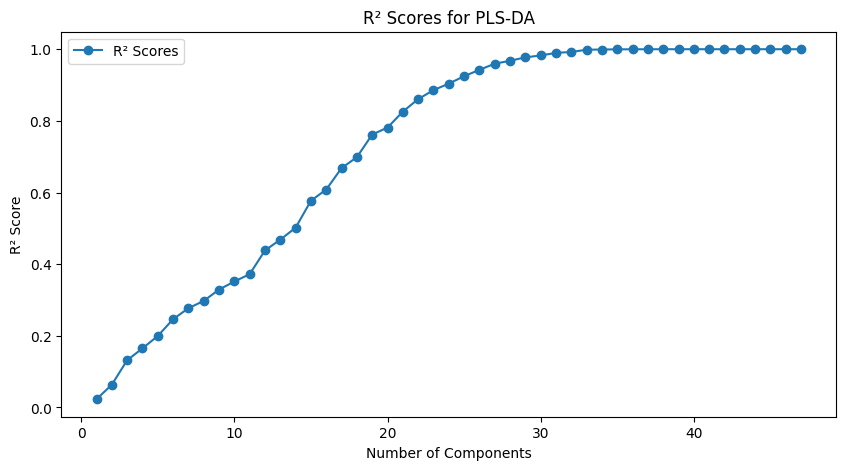

In [74]:
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
import warnings

# Disable warnings for the purpose of this demonstration
warnings.filterwarnings("ignore", category=UserWarning)

# Create a GroupKFold object to be used for cross-validation
group_kfold = GroupKFold(n_splits=5)

# Initialize arrays to store Q² and R² scores for each component
num_components = min(X.shape[0], X.shape[1])
q2_scores = np.zeros(num_components)
r2_scores = np.zeros(num_components)

# Perform PLS-DA and evaluate scores for each number of components
for i in range(1, num_components + 1):
    plsr = PLSRegression(n_components=i)
    
    # Cross-validation to get Q² score
    q2_scores[i - 1] = np.mean(cross_val_score(plsr, X, y, cv=group_kfold, groups=X.index))
    
    # Fit the model to get R² score
    plsr.fit(X, y)
    y_pred = plsr.predict(X)
    r2_scores[i - 1] = r2_score(y, y_pred)

# Plot Q² scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_components + 1), q2_scores, marker='o', label='Q² Scores')
plt.xlabel('Number of Components')
plt.ylabel('Q² Score')
plt.title('Q² Scores for PLS-DA')
plt.legend()
plt.show()

# Plot R² scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_components + 1), r2_scores, marker='o', label='R² Scores')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.title('R² Scores for PLS-DA')
plt.legend()
plt.show()

In [71]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

# Cross-validation to get predicted y values
y_pred = cross_val_predict(plsr, X, y, cv=5)  # You can adjust the number of folds (cv) as needed

# Calculate Q² score
q2 = plsr.score(X, y)
print(f'Q² Score: {q2}')

# Calculate R2 score
r2 = r2_score(y, y_pred)
print(f'R2 Score: {r2}')

print(f"Q2/R2: {q2/r2}.")

Q² Score: 0.06348075500571992
R2 Score: -22.484460449860055
Q2/R2: -0.0028233168034999495.


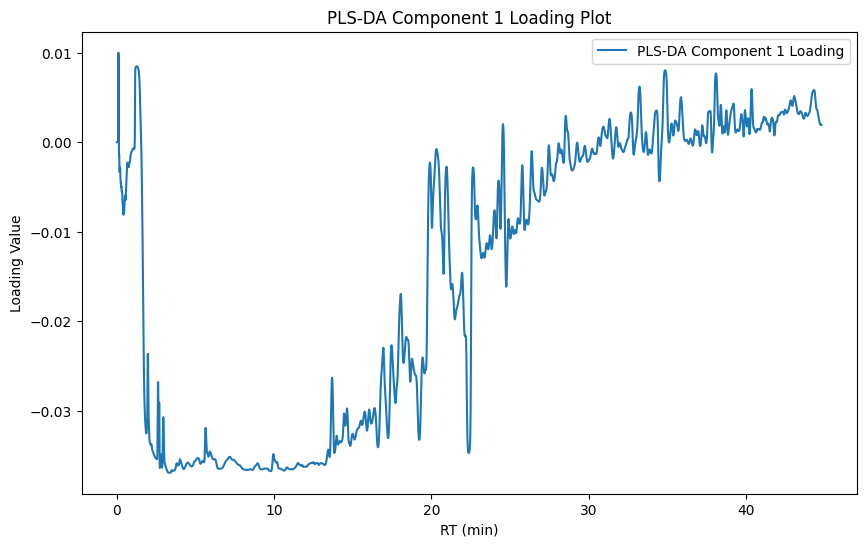

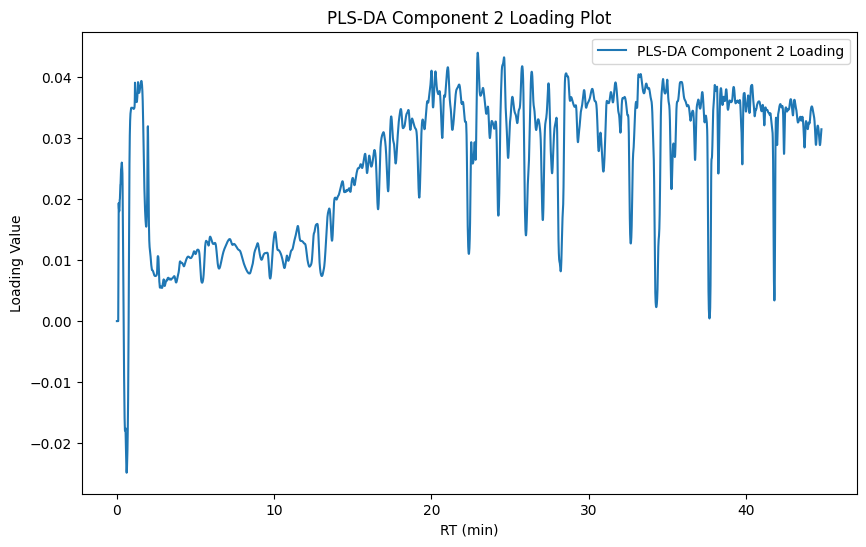

In [61]:
# Loadings PLot
# Access the loadings from the PLSR object
loadings = plsr.x_loadings_

# Plot the loadings for PLS-DA Component 1
plt.figure(figsize=(10, 6))
plt.plot(combined_df2['RT(min)'], loadings[:, 0], label='PLS-DA Component 1 Loading')
plt.xlabel('RT (min)')
plt.ylabel('Loading Value')
plt.title('PLS-DA Component 1 Loading Plot')
plt.legend()
plt.show()

# Plot the loadings for PLS-DA Component 2
plt.figure(figsize=(10, 6))
plt.plot(combined_df2['RT(min)'], loadings[:, 1], label='PLS-DA Component 2 Loading')
plt.xlabel('RT (min)')
plt.ylabel('Loading Value')
plt.title('PLS-DA Component 2 Loading Plot')
plt.legend()
plt.show()


In [76]:
# VIP
from sklearn.cross_decomposition import PLSSVD
from sklearn.preprocessing import StandardScaler

# Standardize the input data
X_standardized = StandardScaler().fit_transform(X)

# Perform PLS-DA using PLSSVD to obtain VIP scores
plssvd = PLSSVD(n_components=1)
plssvd.fit(X_standardized, y)

# Get the VIP scores
vip_scores = plssvd.vip_

# Create a DataFrame for VIP scores
vip_df = pd.DataFrame({'Variable': X.columns, 'VIP Score': vip_scores})

# Sort DataFrame by VIP Score in descending order
vip_df = vip_df.sort_values(by='VIP Score', ascending=False)

# Print or visualize VIP scores
print(vip_df)


AttributeError: 'PLSSVD' object has no attribute 'vip_'

---

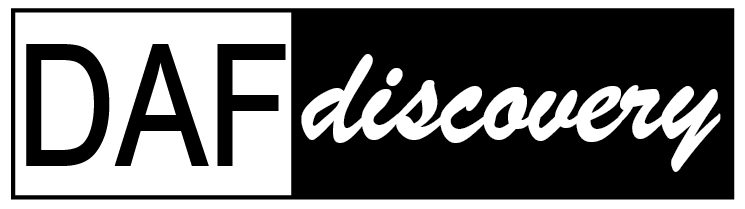

In [23]:
# Create the Target Vector for the supervision tool (PLS-DA)
Metadata = pd.read_csv("Metadata_analitica.csv", sep=";")
Metadata.columns

if ('HPLC_filename') in Metadata.columns and ('BioAct_filename') in Metadata.columns:
    Ordered_Samples = Metadata['Samples'].values.tolist()
    Ordered_HPLC_DAD_filename = Metadata['HPLC_filename'].values.tolist()
    Ordered_BioAct_filename = Metadata['BioAct_filename'].values.tolist()
    print('You are about to merge data from: HPLC-DAD + BioAct. Go for Option 3')
    data_inuse = ['HPLC-DAD', 'BioAct']


elif ('HPLC_filename') in Metadata.columns:
    Ordered_Samples = Metadata['Samples'].values.tolist()
    Ordered_HPLC_DAD_filename = Metadata['HPLC_filename'].values.tolist()    
    print('You are about to work with HPLC-DAD data alone. Have a look in what more you could do with additional data. . Go for Option 5')
    data_inuse = ['HPLC-DAD']
    
else: print('Error (sorry!), please check your Metadata')

print(f'Data in Use: {data_inuse}')

You are about to work with HPLC-DAD data alone. Have a look in what more you could do with additional data. . Go for Option 5
Data in Use: ['HPLC-DAD']


In [36]:
if data_inuse == ['HPLC-DAD']:
    # NMR
    HPLC_DAD = pd.read_csv('combined_data.csv', sep=';',header=0)   # assuming the NMR data was exported and saved as NMR.csv
    HPLC_DADdata = HPLC_DAD.drop(["RT(min)"], axis=1)
    axis = HPLC_DAD["RT(min)"]
    
else: print('Try the next one')

# REORDERING data according to the Metadata (Ordered_Samples)

HPLC_DAD = HPLC_DAD[Ordered_HPLC_DAD_filename] # reorder columns according to the sampleIDs
HPLC_DAD.rename(columns={i:j for i,j in zip(Ordered_HPLC_DAD_filename,Ordered_Samples)}, inplace=True) # rename column headers as sampleIDs

print('Data from NMR is reordered according to the Matadata.')

Data from NMR is reordered according to the Matadata.


In [46]:
# Chose driver to produce highlighted NMR spectra showing highly correlated peaks
from STOCSY import *
%matplotlib notebook

# DRIVER FROM THE HPLC_DAD data
driver = 21.0

corr, covar = STOCSY(driver, HPLC_DADdata, axis)


In [47]:
HPLC_DADdata.shape